In [1]:
import numpy as np
import math
import random as rn
import matplotlib.pyplot as plt

rn.seed(1)

In [2]:
# Generate RRT based on Pseudocode of LaValle 1998 Paper
# TODO
# 1. How do we connect to dot?
# 2. Obstacle Avoidance?
# 3. 

In [3]:
# Build Valid Movement Masking Map
# Implemented from Game Theory example
# n indicates number of grid cells for n x n grid
# Meshgrid X, Y created for n^2 number of cells with x, y values of 0 to xf, yf
n = 21
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X,Y = np.meshgrid(x, y)

# Position function converting position index i_x to position x
def position(i_x):
    return np.array([x[i_x[0]], y[i_x[1]]])

# Define Initial, Final position of the aggressor
# Position index of aggressor
i_x0 = (int(0.05*n), int(0.05*n))
i_xf = (int(0.95*n), int(0.95*n))
# Position of aggressor
x0 = position(i_x0)
xf = position(i_xf)
print("x0: {}, xf: {}".format(x0, xf))

# Building Setup
# Set nB number of buildings
# building_i indicates 4 corners of the building generated in the field
nB = 2
building1 = np.array([0, 0.3, 0.25, 0.75])
building2 = np.array([0.7, 1, 0.25, 0.75])
building = [building1, building2]

# Bound within map
def bound(i_x):
    return (i_x[0] >= 0 and i_x[0]<n and i_x[1] >= 0 and i_x[1]<n)

def bound_building(i_x, building):
    # building: [x0, x1, y0, y1]
    currpos = position(i_x)
    bcheck = np.zeros((nB,1))
    for b in range(nB):
        bnow = building[b]
        bcheck[b] = (currpos[0] >= bnow[0] and currpos[0] <= bnow[1] and currpos[1] >= bnow[2] and currpos[1] <= bnow[3])
    sumcheck = 0
    for b in range(nB):
        sumcheck += bcheck[b]
    return sumcheck


def static_movement_map(X, Y, building):
    # Static Movement Map
    nH = len(X)
    nV = len(X[0])
    
    # For (x, y) coordinate, check if this is within the field bound while outside of building bound
    static_map = np.zeros((nH, nV))
    for i in range(len(X)):
        for j in range(len(Y)):
            # Check if the (i,j) is within field bound
            within_bound = bound((i, j))
            # check if the (i,j) is outside building bound
            within_building = bound_building((i,j), building)
            
            # If we are within_bound but not in building >> True
            # else >> False
            static_map[i,j] = within_bound and not within_building
    return static_map

static_map = static_movement_map(X, Y, building)

x0: [0.05 0.05], xf: [0.95 0.95]


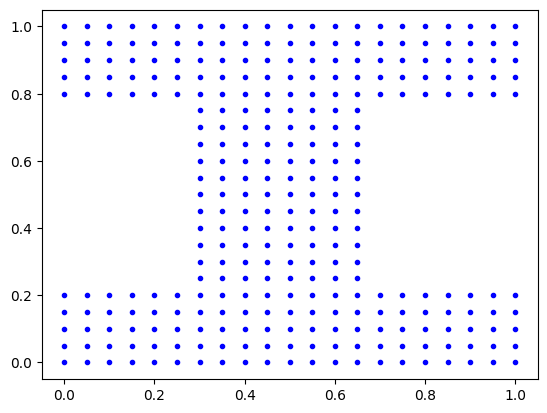

In [4]:
fig = plt.figure()
for i in range(len(X)):
    for j in range(len(Y)):
        if static_map[i,j] == True:
            plt.plot(X[j,i], Y[j,i], '.b')

In [108]:
# Generate RRT
# Based on LaValle Paper
def build_RRT(qinit, delq):
    # Input
    # qinit: Initial node (In index)
    # K: Number of vertices
    # delq: time difference in discrete step
    
    # Output
    # G: Group of Vertex and Edge
    
    # Miscelleneous
    counter = 0
    k = 0
    range_tol = 0.5
    
    # Setup
    G = {}
    keyList = ['vertex', 'edge']
    for i in keyList:
        G[i] = []
    G['vertex'].append(qinit)
    
    # Generate different random nodes until we reach final point
    repeat = True
    while repeat:
        #print("k: {}".format(k))
        # Generate New Random Point
        qrand = rand_conf()
        #print("qrand: {}".format(qrand))
        
        # Find nearest vertex from G
        #print(G['vertex'])
        qnear = nearest_vertex(qrand, G['vertex'])
        #print("qnear: {}".format(qnear))
        
        # Move in direction to qrand for delq amount
        # Also check incremented movement is within valid movement map
        qnew = new_conf(qnear, qrand, delq)
        #print("qnew: {}".format(qnew))
        
        # Generate edge between qnear and closest vertex in G
        qedge = gen_edge(qnew, G['vertex'])
        
        # Update
        G['vertex'].append(qnew)
        G['edge'].append(qedge)
        counter += 1
        k += 1
        
        # Check if we reached proximity for i_xf
        if rangeTo(qnew, i_xf) <= range_tol:
            print("{} iterations to reach xf".format(counter))
            G['edge'].append([[qnew[0], i_xf[0]], [qnew[1], i_xf[1]]])
            repeat = False
            break
    
    
    fig = plt.figure()
    for g in G['vertex']:
        plt.plot(g[0], g[1], '.r')
    
    for e in G['edge']:
        plt.plot(e[0], e[1], '-r')
    
    plt.plot(i_x0[0], i_x0[1], 'ob') # Initial Point
    plt.plot(i_xf[0], i_xf[1], 'xb') # Initial Point
    
    # Plot Settings
    plt.grid()
    plt.axis('square')
    tol = 0.5
    plt.xlim(-tol, n+tol)
    plt.ylim(-tol, n+tol)
    plt.show()
        
        
def rand_conf():
    # Generate random node
    return (rn.randint(0,n), rn.randint(0,n))

def rangeTo(x0, x1):
    return np.sqrt((x0[0] - x1[0])**2 + (x0[1] - x1[1])**2)

def nearest_vertex(q, G):
    # Obtain nearest vertex in G
    d = math.inf
    
    for g in G:
        if rangeTo(q, g) < d:
            gnew = g
            d = rangeTo(q, g)
    return gnew

def new_conf(q0, q1, delq):
    theta = np.arctan2(q1[1]-q0[1], q1[0]-q0[0])
    return (q0[0]+delq*np.cos(theta), q0[1]+delq*np.sin(theta))

def gen_edge(q0, G):
    gc = nearest_vertex(q0, G)
    return [[q0[0], gc[0]], [q0[1], gc[1]]]

502 iterations to reach xf


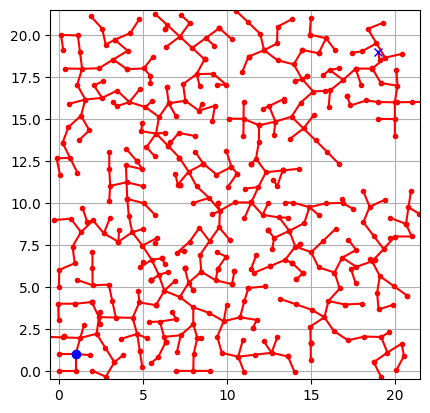

In [109]:
build_RRT(i_x0, 1)

IndexError: list index out of range

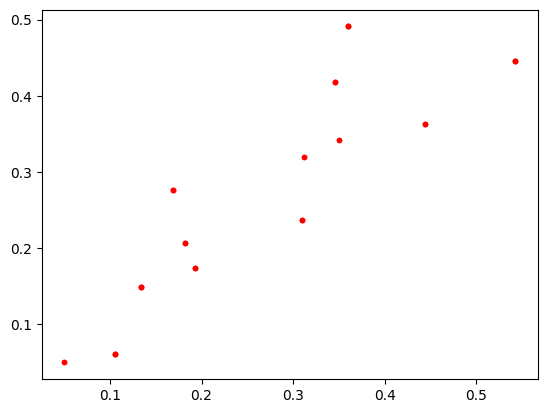

In [171]:
# Generate RRT
# Based on LaValle 1998
def generate_RRT(xinit, K, delt, n):
    # Input
    # i_x: Initial x position (In index)
    # K: Number of vertices
    # delt: time difference in discrete step
    
    # Output
    # Tau: Group of Vertices
    
    Tau = []
    Tau.append(xinit)
    tolerance = 0.1
    
    # Add 1st set of randomly generated points
    xavail = []
    xavail.append((xinit[0], xinit[1]))
    xavail_hist = {}
    xavail_hist['0'] = xinit
    
    repeat = True
    counter = 1
    while repeat:
        # Reset lists holding data
        xrand_list = []
        xnew_list = []
        
        for k in range(K):        
            # Generate Random state xrand
            # Make sure not on the building boundary
            xrand = (rn.randint(0,n), rn.randint(0,n))
            xrand_list.append(xrand)
            
            if bound(xrand) and not bound_building(xrand, building):
                # Find nearest Neighbor in Tau
                min_ind, xnear = nearest_vertex(xrand, xavail)

                # Find Direction to move
                dist = v*dt
                direc = np.arctan2(xrand[1]-xnear[1], xrand[0]-xnear[0])

                # Add new vertex xnew
                xnew = (xnear[0] + dist*np.cos(direc), xnear[1] + dist*np.sin(direc))
                xnew_list.append(xnew)

                if rangeTo(xnew, xf) <= tolerance:
                    repeat = False
                    break
        
        # Update
        for i in range(len(xnew_list)):
            xavail.append(xnew_list[i])
        xavail_hist[str(counter)] = xnew_list
        counter += 1
        
        
    # Visualization      
    fig = plt.figure()
    for i in range(counter):
        for j in range(len(xavail_hist[str(i)])):       # Available Nodes
            currX = xavail_hist[str(i)] # Curr Node
            # Plot all available nodes
            plt.plot(currX[0], currX[1], '.r')
        #    
        #    # Plot Path to Node
        #    # From current X, find next closest node
        #    min_Xind, nearX = nearest_vertex(currX, xavail)
        #    xavail_prime = xavail.copy() # Make new list of xavail excluding itself
        #    xavail_prime.pop(min_Xind)
        #    dummy, nearX = nearest_vertex(currX, xavail_prime)
        #    plt.plot([currX[0], nearX[0]], [currX[1], nearX[1]], '-r')

    plt.plot(x0[0], x0[1], 'ob') # Initial Point
    plt.plot(xf[0], xf[1], 'xb') # Initial Point

    
    # Plot Settings
    plt.grid()
    plt.axis('square')
    tol = 0.1
    plt.xlim(-tol, x[-1]+tol)
    plt.ylim(-tol, y[-1]+tol)
    plt.show()

    return xrand_list, xnew_list, xavail, Tau
    
    
def rangeTo(x0, x1):
    return np.sqrt((x0[0] - x1[0])**2 + (x0[1] - x1[1])**2)
        
def nearest_vertex(xrand, xavail):
    dist_vec = []

    # Compute distance to all vertex in currently in Tau
    for i in range(len(xavail)):
        dist = rangeTo(xrand, xavail[i])
        dist_vec.append(dist)

    # Find nearest neighbor
    min_index = dist_vec.index(min(dist_vec))
    return min_index, xavail[min_index]




Kstep = 5
dt = 1/n
v = 0.1*n

xrand_list, xnew_list, xavail, Tau = generate_RRT(x0, Kstep, dt, n)

